### Machine Learning Model Development

1. Datasource:
    - https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

2. Objective:
    - To classify a person into abnormal or normal using collected physical spine data.
    
3. Encoding:
    - Normal = 0 | Abnormal(Patient) = 1
    
4. Metrics:
    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    - However, my focus would be to improve the overall accuracy as well.
    - Evaluation Metric for Hyperparameter tuning is set as f1 score.
    
5. Scope:
    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

6. Target:
    - Good balance between Recall & Precision. i.e. f1-score >= 80%
    - Difference between Train-Test Accuracy <= 5%
    
7. Recommendation from Exploratory Data Analyses (EDA)
    - Drop pelvic_incidence
    - Use StandarScaler.
    - Downsampling / Upsampling.

In [84]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

import shap

In [6]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [7]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\Back_Pain_"

# Specify number of features and targets

n_features = 12
n_target = 1

In [8]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

# dropcol = ['lumbar_lordosis_angle', 'Direct_tilt', 'thoracic_slope', 'scoliosis_slope']

# df=df.drop(columns=dropcol)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [9]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [10]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [11]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [12]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [13]:
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,47.806,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,92.026,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,63.792,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,46.390,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,64.624,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


In [14]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [15]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [16]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [17]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [18]:
print(df.isnull().sum(), end='\n\n')

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [19]:
# """
#     1. Cell for removing outliers.
#     2. Based on Z-score.
# """
# df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [20]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [21]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [22]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_incidence         |     310 |  60.497 | 17.237 |  26.148 |   46.43 |  58.692 |  72.878 | 129.834 |
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |

In [23]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [24]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 1    165
0     83
Name: Class_att, dtype: int64
After Upsampling: 0    165
1    165
Name: Class_att, dtype: int64


In [25]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [26]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [27]:
X_train.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,44.216,1.507,46.110,42.709,108.630,42.810,0.481,20.060,14.732,11.990,5.366,13.711
1,65.612,23.138,62.582,42.474,124.128,-4.083,0.997,30.042,17.622,13.391,-16.370,21.450
2,71.242,5.268,86.000,65.973,110.703,38.260,0.506,23.053,15.243,14.149,-19.896,8.624
3,56.564,8.961,52.578,47.603,98.777,50.702,0.589,18.145,13.963,12.466,0.744,32.447
4,72.344,16.421,59.869,55.923,70.083,12.073,0.057,31.823,15.713,9.368,-33.489,28.948


In [28]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [29]:
X_test.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
119,76.147,21.936,82.962,54.211,123.932,10.432,0.253,21.593,7.810,11.071,-34.898,43.149
266,74.565,15.724,58.619,58.841,105.417,0.599,0.118,18.055,15.624,10.546,-32.495,16.623
217,83.703,20.268,77.111,63.435,125.480,69.280,0.736,33.812,15.112,14.381,-20.214,11.735
21,83.397,34.311,78.423,49.086,110.467,49.672,0.772,24.926,7.624,13.236,-21.450,16.215
61,78.426,33.426,76.277,45.000,138.554,77.155,0.581,36.628,16.626,7.965,-19.123,16.143


In [30]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [31]:
y_train.head()

,Class_att
0,1
1,0
2,1
3,1
4,1


In [32]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [33]:
y_test.head()

,Class_att
119,1
266,0
217,1
21,1
61,1


In [34]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [35]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [36]:
X_train_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,-0.874219,-1.573776,-0.185890,0.071107,-0.867592,0.629782,0.081267,-0.174050,0.484028,0.056061,1.586385,-1.103375
1,0.469767,0.727519,0.790503,0.052016,0.363499,-0.680754,1.814718,0.970874,1.336862,0.527917,-0.153619,-0.359049
2,0.823414,-1.173648,2.178627,1.960939,-0.702922,0.502621,0.165252,0.169243,0.634823,0.783211,-0.435882,-1.592635
3,-0.098582,-0.780754,0.197507,0.468667,-1.650270,0.850343,0.444082,-0.393699,0.257098,0.216377,1.216386,0.698625
4,0.892636,0.012906,0.629687,1.144535,-3.929591,-0.229237,-1.343119,1.175153,0.773520,-0.827028,-1.524025,0.362097


In [37]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [38]:
X_test_sc_df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,1.131521,0.599640,1.998546,1.005462,0.347930,-0.275098,-0.684676,0.001783,-1.558642,-0.253458,-1.636818,1.727928
1,1.032148,-0.061247,0.555592,1.381577,-1.122818,-0.549905,-1.138196,-0.404022,0.747256,-0.430278,-1.444453,-0.823303
2,1.606150,0.422183,1.651723,1.754767,0.470896,1.369549,0.937914,1.403289,0.596166,0.861349,-0.461338,-1.293424
3,1.586928,1.916200,1.729493,0.589137,-0.721669,0.821557,1.058853,0.384074,-1.613530,0.475713,-0.560282,-0.862544
4,1.274676,1.822046,1.602287,0.257214,1.509435,1.589634,0.417207,1.726281,1.042944,-1.299558,-0.374002,-0.869469


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [98]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [41]:
LR_Best

{'C': 1.0,
 'class_weight': {0: 1, 1: 1.5},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [42]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [43]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [44]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [45]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.71,0.69,17.00
1,0.89,0.87,0.88,45.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.78,0.79,0.78,62.00
weighted avg,0.83,0.82,0.82,62.00


In [ ]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1.05, 1.5, 2]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

In [47]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [48]:
RFC_Best

{'class_weight': {0: 1, 1: 2},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 5,
 'n_estimators': 200}

In [49]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [50]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [51]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [52]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.73,0.47,0.57,17.00
1,0.82,0.93,0.87,45.00
accuracy,0.81,0.81,0.81,0.81
macro avg,0.78,0.70,0.72,62.00
weighted avg,0.80,0.81,0.79,62.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [10000, 1000, 100]
gamma = [0.001, 0.01]
weights = [1.05, 1.5, 2]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

In [54]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [55]:
KSV_Best

{'C': 10000,
 'class_weight': {0: 1, 1: 1.05},
 'gamma': 0.001,
 'kernel': 'linear'}

In [56]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [57]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [58]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [59]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.67,0.71,0.69,17.00
1,0.89,0.87,0.88,45.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.78,0.79,0.78,62.00
weighted avg,0.83,0.82,0.82,62.00


In [ ]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.03, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [50, 100, 150]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric='F1', random_state=RND_STATE)

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

In [61]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [62]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'F1',
 'random_state': 39,
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 50,
 'learning_rate': 0.1}

In [ ]:
# Model: CatBoost Classification (CBC)

CBC = cb.CatBoostClassifier(**CBC_Best)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [64]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [65]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [66]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.71,0.71,0.71,17.00
1,0.89,0.89,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.80,0.80,62.00
weighted avg,0.84,0.84,0.84,62.00


In [67]:
# Artificial Neural Net (ANN) aka DNN Model

n_features = X_train.shape[1] # Get the number of features

# Single Hidden Layer ANN Definition

def ann_model(units=16, dropout_rate=0.2, learn_rate=0.01, momentum=0):
    model = Sequential()
    model.add(Dense(16, activation='relu', kernel_initializer='normal', input_shape=(n_features, )))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the Model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Hyperparameter Tuning

model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=ann_model, epochs=30, batch_size=10, verbose=1)

# Define GridSearch Parameters

units = [16, 24]
dropout_rate = [0.1, 0.2]
learn_rate = [0.001, 0.01]
momentum = [0.2, 0.4]
batch_size = [30, 60]
epochs = [30]

param_grid = dict(units=units, dropout_rate=dropout_rate, learn_rate=learn_rate, momentum=momentum, batch_size=batch_size,
                 epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
DNN_Best = grid_result.best_params_

In [87]:
print("------ DNN Best Parameters ------")

------ DNN Best Parameters ------


In [70]:
DNN_Best

{'batch_size': 30,
 'dropout_rate': 0.1,
 'epochs': 30,
 'learn_rate': 0.01,
 'momentum': 0.2,
 'units': 24}

In [ ]:
# Get the Best ANN Parameters Using Dictionary Call

units = DNN_Best.get("units")
dropout_rate = DNN_Best.get("dropout_rate")
learn_rate = DNN_Best.get("learn_rate")
momentum = DNN_Best.get("momentum")
batch_size = DNN_Best.get("batch_size")
epochs = DNN_Best.get("epochs")

n_features = X_train.shape[1]

# define model

model = Sequential()
model.add(Dense(units=units, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# compile the model

opt= tf.keras.optimizers.Adam(learning_rate=learn_rate)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=epochs, batch_size=batch_size)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [72]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [73]:
print("-------- Neural Net -------- ")

-------- Neural Net -------- 


In [74]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.33,1.00,0.50,17.00
1,1.00,0.24,0.39,45.00
accuracy,0.45,0.45,0.45,0.45
macro avg,0.67,0.62,0.45,62.00
weighted avg,0.82,0.45,0.42,62.00


In [75]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [76]:
print("Evaluation Summary:")

Evaluation Summary:


In [77]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.85,0.82,12,39,6,5,0.67,0.71,0.69,0.87,0.79
1,Random_Forest,0.99,0.81,8,42,3,9,0.73,0.47,0.57,0.93,0.7
2,Kernel_SVM,0.88,0.82,12,39,6,5,0.67,0.71,0.69,0.87,0.79
3,CatBoost,0.95,0.84,12,40,5,5,0.71,0.71,0.71,0.89,0.8
4,DNN,0.95,0.84,17,11,34,0,0.33,1.0,0.5,0.24,0.62


In [78]:
print("ROC Curve: ")

ROC Curve: 


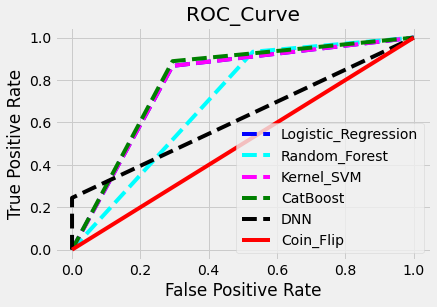

In [79]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [80]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [81]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [82]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.67    0.71      0.69    17.00
           1                  0.89    0.87      0.88    45.00
           accuracy           0.82    0.82      0.82     0.82
           macro avg          0.78    0.79      0.78    62.00
           weighted avg       0.83    0.82      0.82    62.00
RFC_Rep_df 0                  0.73    0.47      0.57    17.00
           1                  0.82    0.93      0.87    45.00
           accuracy           0.81    0.81      0.81     0.81
           macro avg          0.78    0.70      0.72    62.00
           weighted avg       0.80    0.81      0.79    62.00
KSV_Rep_df 0                  0.67    0.71      0.69    17.00
           1                  0.89    0.87      0.88    45.00
           accuracy           0.82    0.82      0.82     0.82
           macro avg          0.78    0.79      0.78    62.00
           weighted avg       0.83    0.82      0.82    62.00
CBC_Rep_df 0                  0.71    0.71      0.71    17.00
           1                  0.89    0.89      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.80      0.80    62.00
           weighted avg       0.84    0.84      0.84    62.00
DNN_Rep_df 0                  0.33    1.00      0.50    17.00
           1                  1.00    0.24      0.39    45.00
           accuracy           0.45    0.45      0.45     0.45
           macro avg          0.67    0.62      0.45    62.00
           weighted avg       0.82    0.45      0.42    62.00

In [88]:
explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [99]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


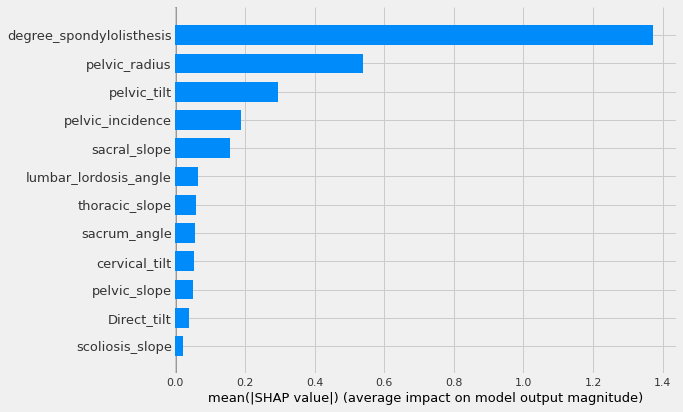

In [90]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='bar', max_display=len(featlst))

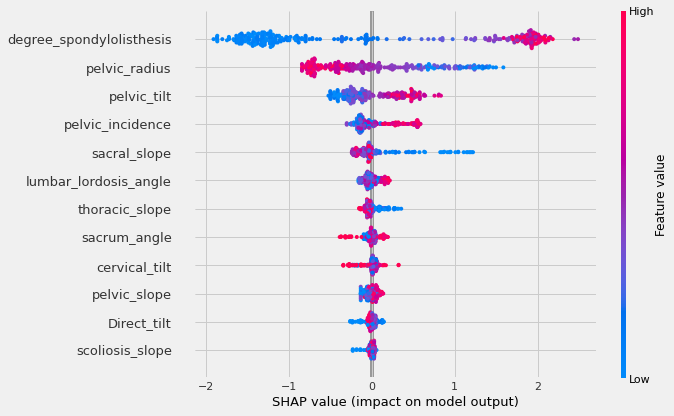

In [101]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='dot', max_display=len(featlst), title="CatBoost Model Explainer")

### SHAP Dependence Plot

    1. Dependence plot is a scatter plot that shows the effect a single feature has on the predictions made by the model.
    2. Each dot is a single prediction (row) from the dataset.
    3. The x-axis is the value of the feature (from the X matrix).
    4. The y-axis is the SHAP value for that feature, which represents how much knowing that feature's value changes the output of the model for that sample's prediction.
    5. The color corresponds to a second feature that may have an interaction effect with the feature we are plotting.
    6. By default this second feature is chosen automatically. 
    7. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring.

In [96]:
print("------ SHAP Dependence Plot ------")

------ SHAP Dependence Plot ------


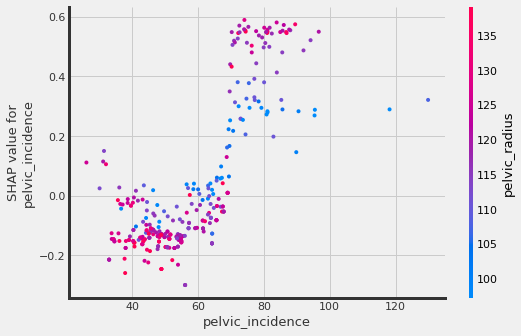

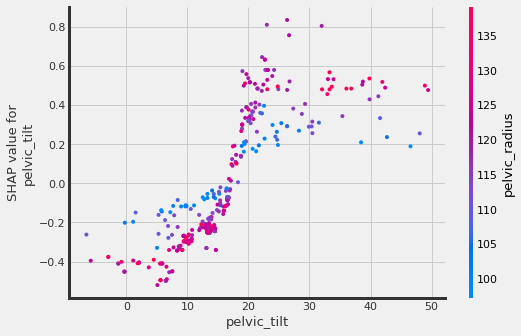

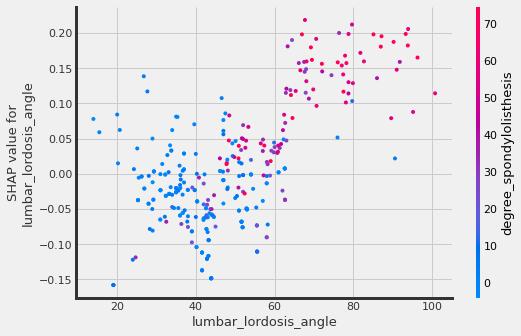

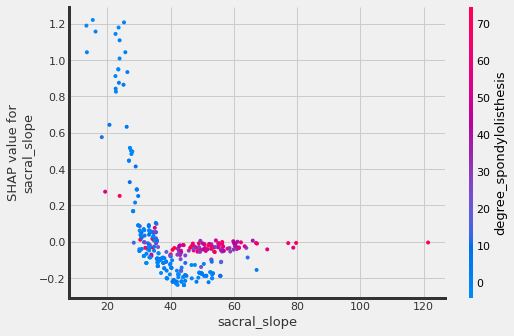

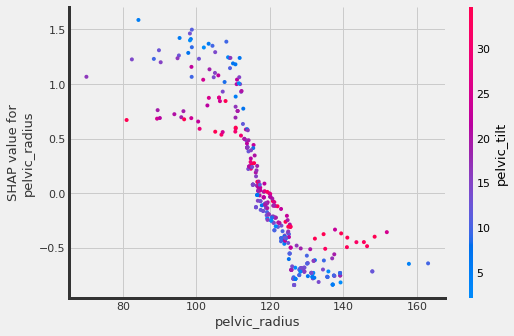

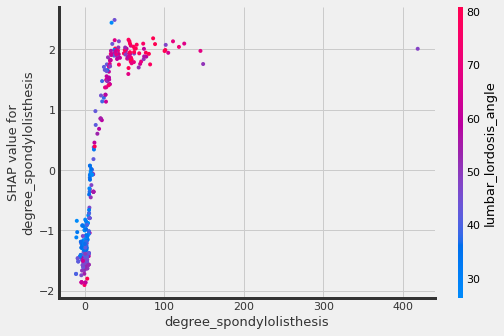

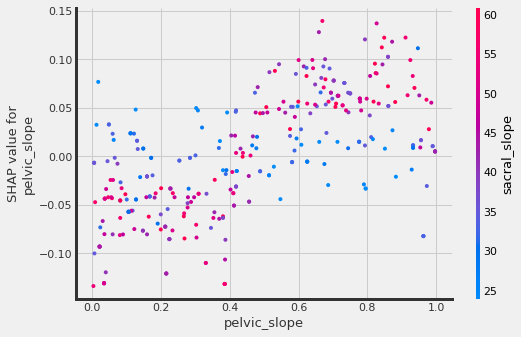

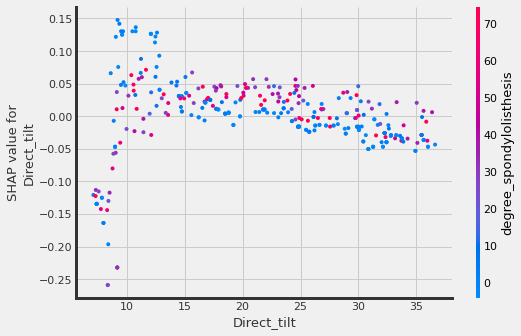

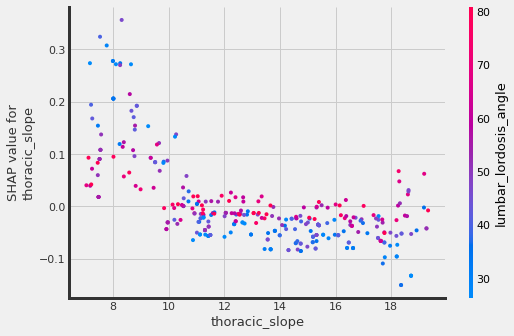

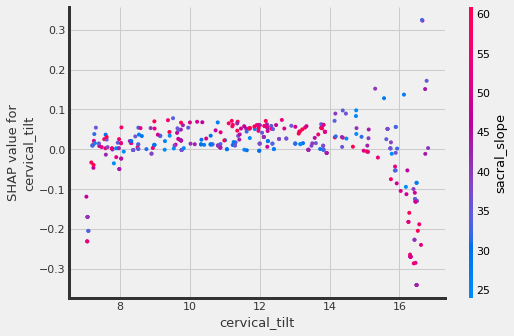

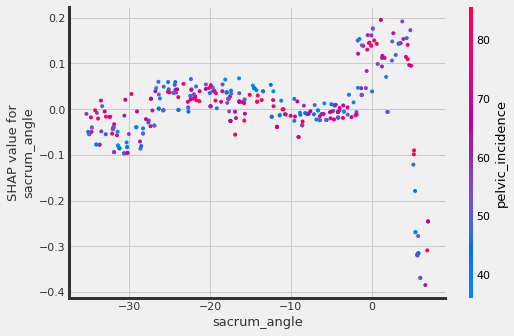

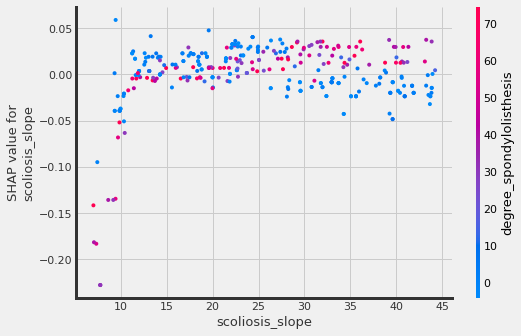

In [97]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

In [102]:
!jupyter nbconvert --output-dir='C:\DSML_Case_Studies\01_Classification\00_Final_Reports' MLM_CLF_Dataset_Back_Pain_R1.ipynb --to html

C:\ProgramData\Anaconda3\lib\site-packages\traitlets\traitlets.py:2196: FutureWarning: Supporting extra quotes around Unicode is deprecated in traitlets 5.0. Use 'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports' instead of "'C:\\DSML_Case_Studies\\01_Classification\\00_Final_Reports'" – or use CUnicode.
  warn(
[NbConvertApp] Converting notebook MLM_CLF_Dataset_Back_Pain_R1.ipynb to html
[NbConvertApp] Writing 1473574 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Back_Pain_R1.html
